# Real Estate Image Classification with MobileNetV2 (Softmax Function)

The following code uses the MobileNetV2 architecture to classify real estate images. Below is an overview of the model, hyperparameters, and training process.

## Dataset

The REI dataset online has been taken to train this data. It can be replaced by Zameen's data once the data is obtained.

## Model Architecture

We use the MobileNetV2 model pre-trained on ImageNet, excluding the top layers (`include_top=False`). The model is extended with custom dense layers for classification:

- **Base Model**: MobileNetV2 (pre-trained, layers frozen)
- **Additional Layers**:
  - Dense layer with 1024 units, ReLU activation
  - Dropout layer with 0.3 dropout rate
  - Dense layer with 512 units, ReLU activation
  - Dropout layer with 0.1 dropout rate
  - Dense layer with 256 units, ReLU activation
  - Output layer with 6 units, softmax activation

The final layer uses softmax activation to output probabilities for each class.

## Hyperparameters

- **Optimizer**: Adam with a learning rate of 0.001
- **Loss Function**: Categorical Crossentropy
- **Metrics**: Accuracy
- **Callbacks**:
  - EarlyStopping with patience of 40 epochs
  - LearningRateScheduler to reduce the learning rate by 10% every 5 epochs

## Data Augmentation and Preprocessing

We use `ImageDataGenerator` for data augmentation and preprocessing:

- **Training Data Augmentation**:
  - Rescaling (1./255)
  - Rotation (20 degrees)
  - Width and height shifts (20%)
  - Shear and zoom (20%)
  - Horizontal flips
  - Brightness adjustment (range [0.8, 1.2])
  - Fill mode: nearest

- **Validation Data Augmentation**:
  - Rescaling (1./255)


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2  
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.metrics import confusion_matrix
import seaborn as sns


data_dir = '/kaggle/input/real-estate'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

image_files = []
labels = []

test_images = []
test_labels = []

for folder in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder)
    if os.path.isdir(folder_path):
        images = os.listdir(folder_path)
        for i, file in enumerate(images):
            file_path = os.path.join(folder_path, file)
            if os.path.isfile(file_path) and file.endswith('.jpg'):
                if i <= 2:  # Take only 2 images from each folder for testing
                    test_images.append(file_path)
                    test_labels.append(folder)
                else:
                    image_files.append(file_path)
                    labels.append(folder)

train_files, val_files, train_labels, val_labels = train_test_split(image_files, labels, test_size=0.2, random_state=42)

mobilenet_model = MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224, 224, 3),
    pooling='avg' 
)

for layer in mobilenet_model.layers:
    layer.trainable = False

fc1 = Dense(1024, activation='relu')(mobilenet_model.output)
dc1 = Dropout(0.3)(fc1)
fc2 = Dense(512, activation='relu')(dc1)
dc2 = Dropout(0.1)(fc2)
fc3 = Dense(256, activation='relu')(dc2)
output_layer = Dense(6, activation='softmax')(fc3)

model = Model(mobilenet_model.input, output_layer)


optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)

def scheduler(epoch, lr):
    if epoch % 5 == 0 and epoch != 0:
        return lr * 0.9
    else:
        return lr

lr_scheduler = LearningRateScheduler(scheduler)

history = model.fit(
    train_datagen.flow_from_directory(data_dir, target_size=(224, 224), batch_size=32, class_mode='categorical'),
    steps_per_epoch=len(train_files) // 32,
    epochs=100,
    validation_data=val_datagen.flow_from_directory(data_dir, target_size=(224, 224), batch_size=32, class_mode='categorical'),
    validation_steps=len(val_files) // 32,
    callbacks=[early_stopping, lr_scheduler]
)

for epoch in range(len(history.history['accuracy'])):
    print(f"Epoch {epoch+1}:")
    print(f"   Training Accuracy: {history.history['accuracy'][epoch]}")
    print(f"   Validation Accuracy: {history.history['val_accuracy'][epoch]}")
    print(f"   Training Loss: {history.history['loss'][epoch]}")
    print(f"   Validation Loss: {history.history['val_loss'][epoch]}")

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

model.save('real_estate_model_mobilenet_softmax.h5')


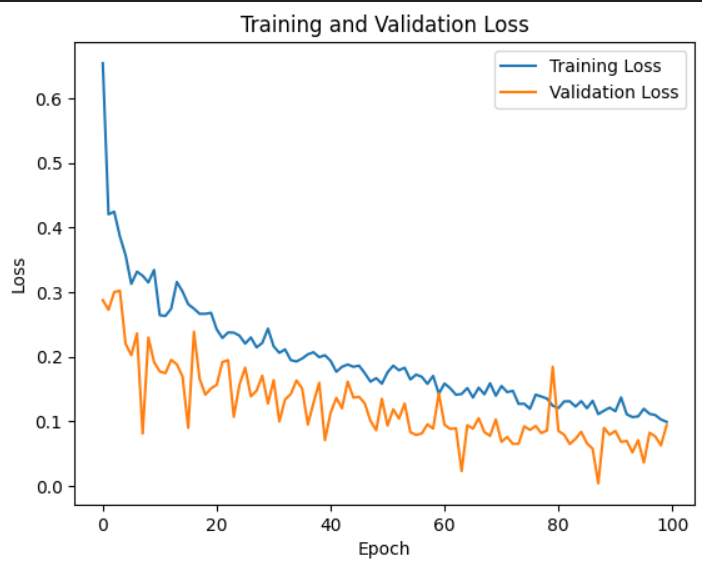

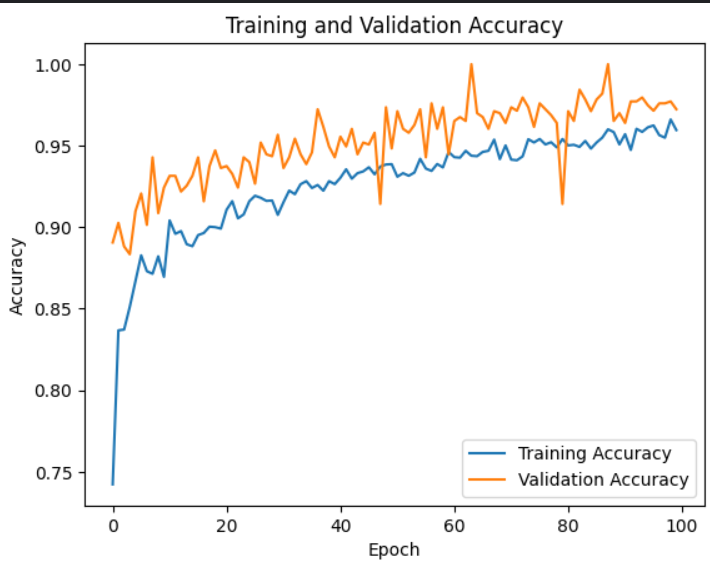

# Real Estate Image Classification with MobileNetV2 (Sigmoid Function)

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2  
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.metrics import confusion_matrix
import seaborn as sns


data_dir = '/kaggle/input/real-estate'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

image_files = []
labels = []

test_images = []
test_labels = []

for folder in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder)
    if os.path.isdir(folder_path):
        images = os.listdir(folder_path)
        for i, file in enumerate(images):
            file_path = os.path.join(folder_path, file)
            if os.path.isfile(file_path) and file.endswith('.jpg'):
                if i <= 2:  # Take only 2 images from each folder for testing
                    test_images.append(file_path)
                    test_labels.append(folder)
                else:
                    image_files.append(file_path)
                    labels.append(folder)

train_files, val_files, train_labels, val_labels = train_test_split(image_files, labels, test_size=0.2, random_state=42)

mobilenet_model = MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224, 224, 3),
    pooling='avg' 
)

for layer in mobilenet_model.layers:
    layer.trainable = False

fc1 = Dense(1024, activation='relu')(mobilenet_model.output)
dc1 = Dropout(0.3)(fc1)
fc2 = Dense(512, activation='relu')(dc1)
dc2 = Dropout(0.1)(fc2)
fc3 = Dense(256, activation='relu')(dc2)
output_layer = Dense(6, activation='softmax')(fc3)

model = Model(mobilenet_model.input, output_layer)


optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)

def scheduler(epoch, lr):
    if epoch % 5 == 0 and epoch != 0:
        return lr * 0.9
    else:
        return lr

lr_scheduler = LearningRateScheduler(scheduler)

history = model.fit(
    train_datagen.flow_from_directory(data_dir, target_size=(224, 224), batch_size=32, class_mode='categorical'),
    steps_per_epoch=len(train_files) // 32,
    epochs=100,
    validation_data=val_datagen.flow_from_directory(data_dir, target_size=(224, 224), batch_size=32, class_mode='categorical'),
    validation_steps=len(val_files) // 32,
    callbacks=[early_stopping, lr_scheduler]
)

for epoch in range(len(history.history['accuracy'])):
    print(f"Epoch {epoch+1}:")
    print(f"   Training Accuracy: {history.history['accuracy'][epoch]}")
    print(f"   Validation Accuracy: {history.history['val_accuracy'][epoch]}")
    print(f"   Training Loss: {history.history['loss'][epoch]}")
    print(f"   Validation Loss: {history.history['val_loss'][epoch]}")

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

model.save('real_estate_model_mobilenet_2_sigmoid.h5')


## Making Predictions

The following test data shows the results of the model.

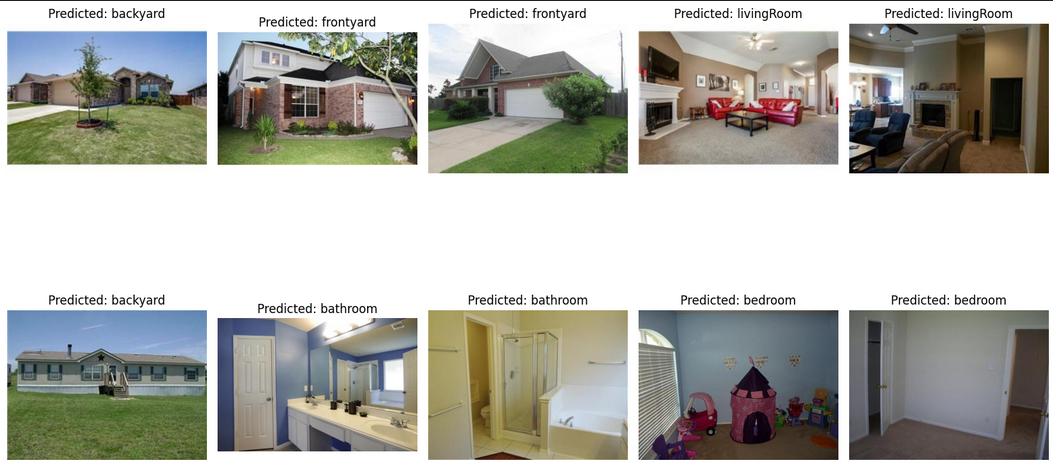

## Probabilities

The probabilities for the model can be obtained using the following code. The models saved in the H5 files are loaded and given the input image to give results.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predictions for /kaggle/input/real-estate/frontyard/frontyard (293).jpg
backyard: 0.99
bathroom: 0.00
bedroom: 0.00
frontyard: 0.01
kitchen: 0.00
livingRoom: 0.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Predictions for /kaggle/input/real-estate/frontyard/frontyard (120).jpg
backyard: 0.03
bathroom: 0.00
bedroom: 0.00
frontyard: 0.97
kitchen: 0.00
livingRoom: 0.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Predictions for /kaggle/input/real-estate/frontyard/frontyard (70).jpg
backyard: 0.00
bathroom: 0.00
bedroom: 0.00
frontyard: 1.00
kitchen: 0.00
livingRoom: 0.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Predictions for /kaggle/input/real-estate/livingRoom/living_room (459).jpg
backyard: 0.00
bathroom: 0.00
bedroom: 0.00
frontyard: 0.00
kitchen: 0.00
livingRoom: 1.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Predictions for /kaggle/input/real-estate/livingRoom/living_room (413).jpg
backyard: 0.00
bathroom: 0.00
bedroom: 0.00
frontyard: 0.00
kitchen: 0.00
livingRoo

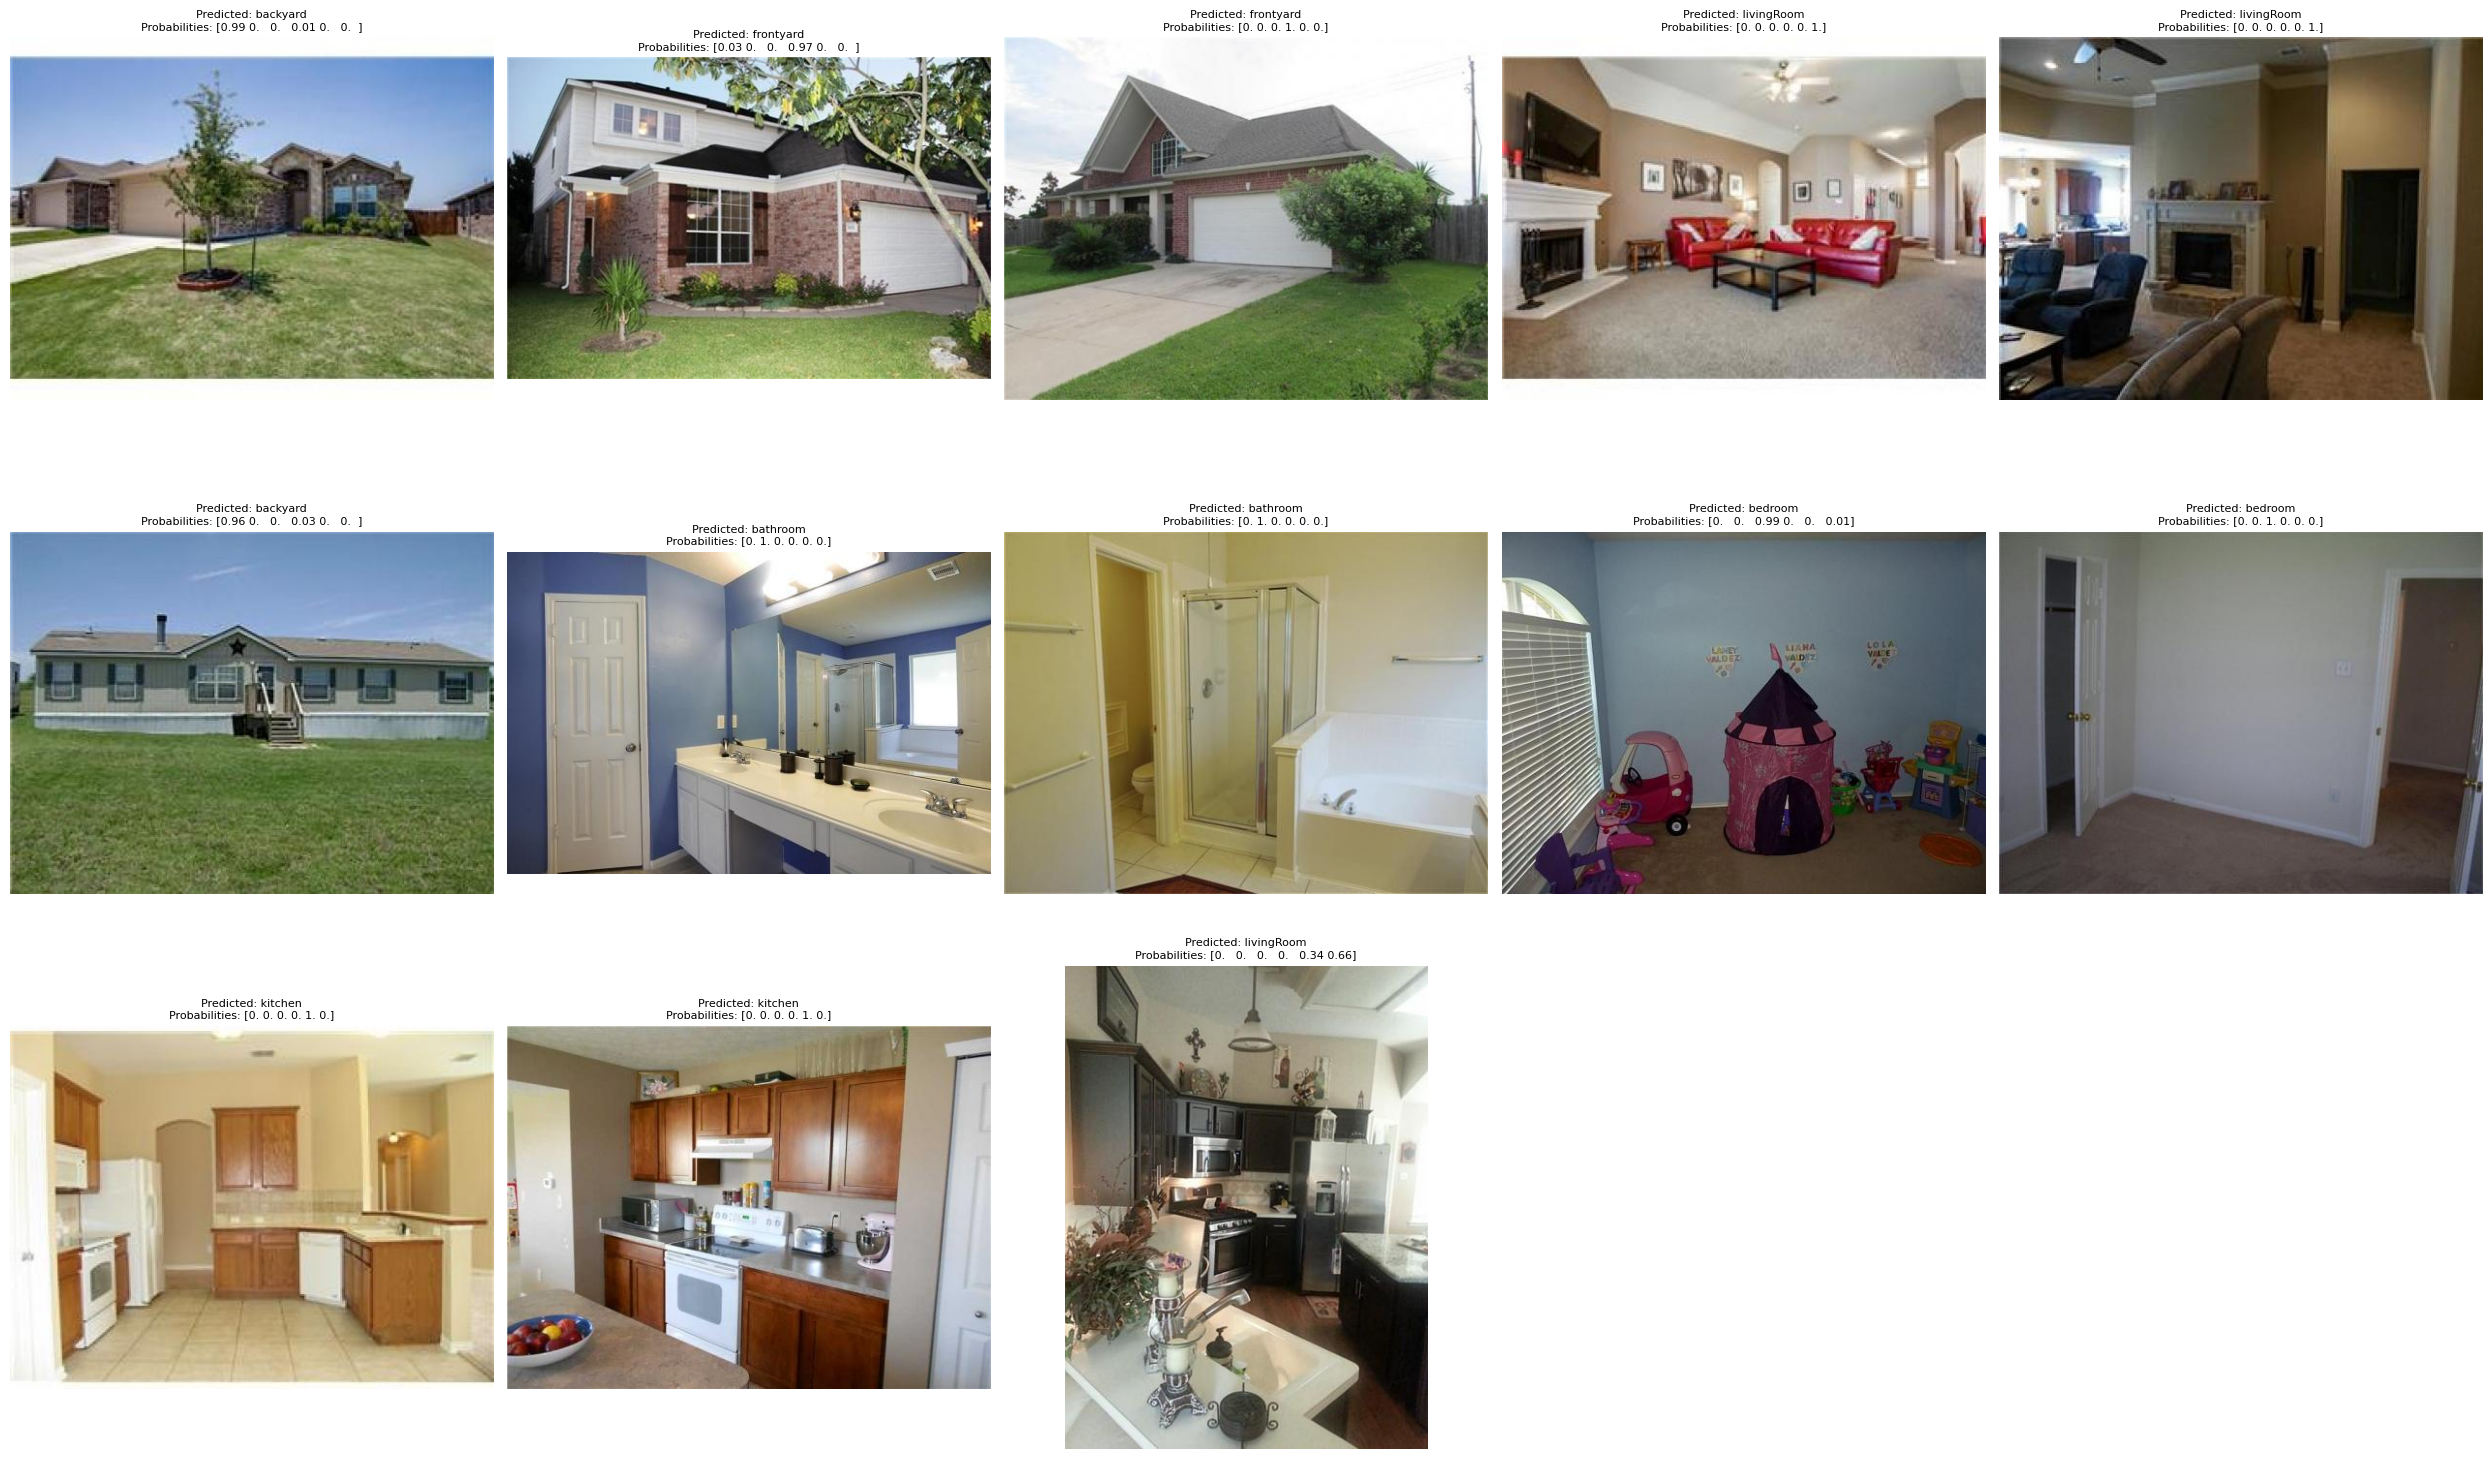

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
import re

class_labels = ['backyard', 'bathroom', 'bedroom', 'frontyard', 'kitchen', 'livingRoom']

model = tf.keras.models.load_model('/kaggle/input/my-models-path/real_estate_model_mobilenet.h5')  # softmax

# can also use model with sigmoid
# model = tf.keras.models.load_model('/kaggle/input/my-models-path/real_estate_model_mobilenet_2_sigmoid.h5')
predictions = []
true_labels = []

for img_path in test_images:
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    prediction = model.predict(img_array)[0]
    prediction = np.round(prediction, 2)
    predictions.append(prediction)
    print("Predictions for", img_path)
    for i, prob in enumerate(prediction):
        print(f"{class_labels[i]}: {prob:.2f}")

num_predictions = len(predictions)
rows = (num_predictions - 1) // 5 + 1
cols = min(5, num_predictions)

plt.figure(figsize=(5 * cols, 5 * rows))
for i, (img_path, prediction) in enumerate(zip(test_images[:num_predictions], predictions)):
    img = plt.imread(img_path)
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(f'Predicted: {class_labels[np.argmax(prediction)]}\nProbabilities: {prediction}', fontsize=8)
    plt.axis('off')

plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=2.0)
plt.show()


# Softmax and Sigmoid functions

## Sigmoid Function
A sigmoid function gives the probabilities independently of each other. It could predict 1.0 for both living room or bedroom at once.

## Softmax Function
A softmax function relates all probabilities together. If a certain class is 0.97, the remaining class probabilities have to sum to 0.03.

## Reason of using both functions
A softmax function tries to fit images that are not real estate into a certain classification as well, as the sum as to be equal to 1 in any case. Sigmoid does not have this restriction. However, a sigmoid function may give 2-3 predictions with high probability values and to shortlist the most likely one we can then also get the top prediction from softmax and compare whether it is also a high prediction by the sigmoid function.

# **Future Upgrades**

The real Zameen dataset can be augmented by performing different image processing techniques and increasing the total number of images by resaving the dataset first before applying the model. This approach should only be applied if the data is diverse enough or else overfitting would occur.

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from shutil import copyfile

def augment_and_save(image_path, output_dir):
    image = cv2.imread(image_path)
    
    augmentations = [
        ("original", image),  
        ("flip_horizontal", cv2.flip(image, 1)), 
        ("flip_vertical", cv2.flip(image, 0)),  
        ("rotate_90", np.rot90(image)),  
        ("rotate_180", np.rot90(image, 2)),  
        ("rotate_270", np.rot90(image, 3)),  
        ("brightness_increase", cv2.convertScaleAbs(image, alpha=1.2, beta=0)),  
        ("brightness_decrease", cv2.convertScaleAbs(image, alpha=0.8, beta=0))   
    ]
    
    for name, augmented_image in augmentations:
        output_file = os.path.join(output_dir, f"{name}_{os.path.basename(image_path)}")
        cv2.imwrite(output_file, augmented_image)

def process_directory(input_dir, output_dir):

    for class_name in os.listdir(input_dir):
        class_dir = os.path.join(input_dir, class_name)
        output_class_dir = os.path.join(output_dir, class_name)
        os.makedirs(output_class_dir, exist_ok=True)
        
        for image_name in tqdm(os.listdir(class_dir), desc=f"Processing {class_name}"):
            image_path = os.path.join(class_dir, image_name)
            output_image_path = os.path.join(output_class_dir, image_name)

            copyfile(image_path, output_image_path)
            
            augment_and_save(image_path, output_class_dir)

def main(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    
    input_train_dir = os.path.join(input_dir, "train")
    input_validation_dir = os.path.join(input_dir, "validation")
    output_train_dir = os.path.join(output_dir, "augmented_train")
    output_validation_dir = os.path.join(output_dir, "augmented_validation")

    process_directory(input_train_dir, output_train_dir)
    process_directory(input_validation_dir, output_validation_dir)

if __name__ == "__main__":
    input_dir = "real-estate-dataset"
    output_dir = "augmented_real-estate-dataset"
    main(input_dir, output_dir)